<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


### Full Name : Mahdi Shafiei
### Student Number : 99109409
___

# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [80]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sn

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [3]:
###############################################################
##                Compose your transformations               ##
###############################################################
transformation = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.1307,), (0.3081,))])

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [4]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [6]:
###############################################################
##           Load the datasets into train/valid              ##
##                       dataloaders                         ##
###############################################################
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> ReLU --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1gQzafyxTkuvQr8T-xUncLmedX94LnY_l/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [58]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################
class ResidualClassifier(nn.Module):
    def __init__(self):
        super(ResidualClassifier,self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
                                   nn.ReLU(),
                                   nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
                                   nn.ReLU())
        
        self.conv3 = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2),
                                   nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=1),
                                   nn.ReLU())
        
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                                   nn.ReLU(),
                                   nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                                   nn.ReLU())

        self.adpavgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flat1 = nn.Flatten()
        self.lin1 = nn.Linear(64, 10)
        self.relu = nn.ReLU()


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x) + x
        x = self.conv3(x)
        x = self.conv4(x) + x
        x = self.adpavgpool(x)
        x = self.flat1(x)
        x = self.lin1(x)
        return x

# Train Model (30 Points)

In [84]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################
model = ResidualClassifier().to(device)
criterion = nn.CrossEntropyLoss() # Write your code here
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # Write your code here
num_epoch = 20

In [85]:
######################################################################
##        Train your model (Complete the code below)                ##
######################################################################
train_accuracy = []
valid_accuracy = []
for epoch in range(num_epoch):
    correct = 0
    total = 0
    f1_train = []
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_accuracy.append(100 * correct / total)
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.4f}' 
                   .format(epoch + 1, num_epoch, loss.item(), 100 * correct / total))

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            del images, labels, outputs
    
        valid_accuracy.append(100 * correct / total)
        print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}' 
                   .format(epoch + 1, num_epoch, loss.item(), 100 * correct / total))
        print()


Epoch [1/20], Train Loss: 0.1495, Train Accuracy: 40.8720
Epoch [1/20], Validation Loss: 0.1973, Validation Accuracy: 89.9600

Epoch [2/20], Train Loss: 0.0671, Train Accuracy: 91.9220
Epoch [2/20], Validation Loss: 0.1255, Validation Accuracy: 94.5200

Epoch [3/20], Train Loss: 0.0256, Train Accuracy: 95.1340
Epoch [3/20], Validation Loss: 0.0043, Validation Accuracy: 96.0500

Epoch [4/20], Train Loss: 0.1404, Train Accuracy: 96.1580
Epoch [4/20], Validation Loss: 0.0398, Validation Accuracy: 96.6100

Epoch [5/20], Train Loss: 0.0232, Train Accuracy: 96.8600
Epoch [5/20], Validation Loss: 0.0077, Validation Accuracy: 96.9400

Epoch [6/20], Train Loss: 0.0255, Train Accuracy: 97.3000
Epoch [6/20], Validation Loss: 0.1742, Validation Accuracy: 97.4000

Epoch [7/20], Train Loss: 0.0753, Train Accuracy: 97.6340
Epoch [7/20], Validation Loss: 0.2103, Validation Accuracy: 97.1600

Epoch [8/20], Train Loss: 0.0101, Train Accuracy: 97.8920
Epoch [8/20], Validation Loss: 0.0219, Validation Acc

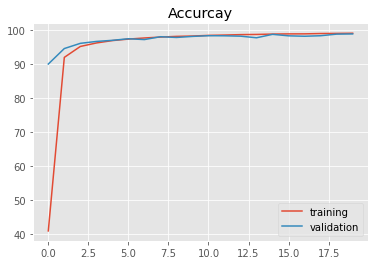

In [86]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
plt.plot(train_accuracy, label='training')
plt.plot(valid_accuracy, label='validation')
plt.title('Accurcay')
plt.legend()
plt.show()

# Test Model (20 Points)

10000
Test Accuracy of the model: 99.06 %


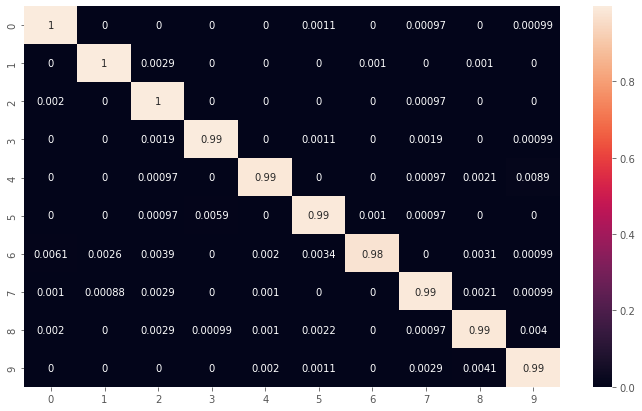

In [87]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################

test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
print(len(test_data))
y_true = []
y_pred = []
with torch.no_grad():
    total = 0
    correct = 0
    for images,labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      out = model(images)
      _, predicted = torch.max(out.data, 1)
      total += images.size(0)
      correct += (predicted == labels).sum().item()
      y_true.extend(labels.cpu().numpy())
      y_pred.extend(predicted.cpu().numpy())
print('Test Accuracy of the model: {} %'.format(100 * correct / total))
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in range(10)],
                     columns = [i for i in range(10)])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.show()